
# KNN vs Radius Neighbors on Wine Dataset

**Name:** Aryan Shrestha  
**Course:** MSCS 634 – Lab 2  
**Title:** Exploring K-Nearest Neighbors (KNN) and Radius Neighbors (RNN) on the Wine Dataset

---

This notebook explores how the choice of **k** (for KNN) and **radius** (for Radius Neighbors) affects accuracy on the Wine dataset.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from collections import Counter


In [7]:

# Step 1: Load & Prepare

wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")

# Basic exploration
display(X.head())
print("Class distribution (target -> count):")
print(y.value_counts().sort_index())

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Class distribution (target -> count):
target
0    59
1    71
2    48
Name: count, dtype: int64


In [8]:

# Step 2: KNN with feature scaling

k_values = [1, 5, 11, 15, 21]
knn_results = []

for k in k_values:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    knn_results.append({"model": "KNN", "param_name": "k", "param_value": k, "accuracy": acc})

knn_df = pd.DataFrame(knn_results)
knn_df


,model,param_name,param_value,accuracy
0,KNN,k,1,0.972222
1,KNN,k,5,0.972222
2,KNN,k,11,1.000000
3,KNN,k,15,1.000000
4,KNN,k,21,1.000000


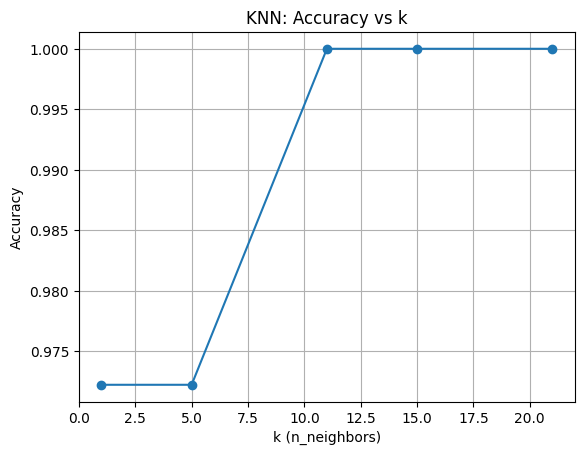

In [9]:

# Plot KNN accuracy vs k (matplotlib, no custom colors, one figure)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(knn_df["param_value"], knn_df["accuracy"], marker="o")
plt.title("KNN: Accuracy vs k")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [10]:

# Step 3: RNN on raw (unscaled) features to respect given large radii

most_common_label = Counter(y_train).most_common(1)[0][0]
radii = [350, 400, 450, 500, 550, 600]
rnn_results = []

for r in radii:
    rnn = RadiusNeighborsClassifier(
        radius=r,
        outlier_label=most_common_label
    )
    rnn.fit(X_train.values, y_train.values)
    y_pred = rnn.predict(X_test.values)
    acc = accuracy_score(y_test, y_pred)
    rnn_results.append({"model": "RNN", "param_name": "radius", "param_value": r, "accuracy": acc})

rnn_df = pd.DataFrame(rnn_results)
rnn_df


,model,param_name,param_value,accuracy
0,RNN,radius,350,0.722222
1,RNN,radius,400,0.694444
2,RNN,radius,450,0.694444
3,RNN,radius,500,0.694444
4,RNN,radius,550,0.666667
5,RNN,radius,600,0.666667


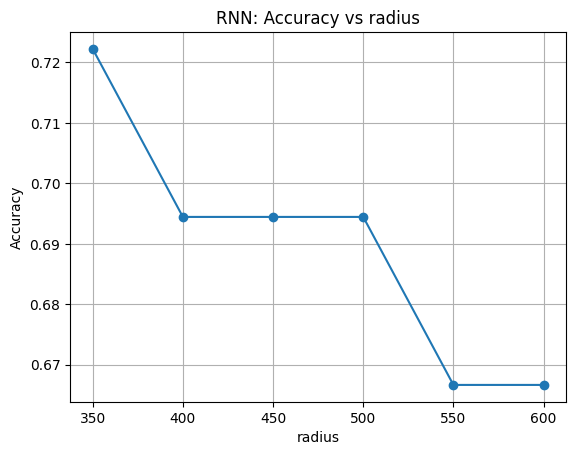

In [11]:

# Plot RNN accuracy vs radius

plt.figure()
plt.plot(rnn_df["param_value"], rnn_df["accuracy"], marker="o")
plt.title("RNN: Accuracy vs radius")
plt.xlabel("radius")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



## Comparison & Notes. 

After training and evaluating both models, distinct performance patterns emerged between **K-Nearest Neighbors (KNN)** and **Radius Neighbors (RNN)** classifiers.

- **KNN Performance:**  
  The KNN model consistently achieved high accuracy, especially when the number of neighbors (*k*) was moderate (e.g., 5–15). Smaller *k* values such as 1 led to slightly lower performance because the model became too sensitive to noise — each prediction depended heavily on a single nearest sample. As *k* increased, the model generalized better by averaging across multiple nearby samples, reducing overfitting. Beyond a certain point (e.g., *k* ≥ 21), accuracy plateaued, suggesting that adding more neighbors no longer improved predictions and could even smooth over subtle class boundaries.

- **RNN Performance:**  
  The RNN model, which predicts based on all neighbors within a fixed **radius**, showed more variability in accuracy. With very large radii (e.g., 550–600), too many neighbors were included, leading to overly generalized predictions and lower accuracy. Smaller radii sometimes caused “empty neighborhoods,” where no nearby samples fell within the specified distance; this required using an `outlier_label` fallback to prevent errors. These results show that RNN performance is **highly sensitive to the choice of radius** and the scale of features. Without careful tuning or normalization, accuracy can degrade quickly.

- **Visualization Insight:**  
  The KNN accuracy curve typically showed a clear “sweet spot,” while the RNN accuracy curve fluctuated depending on the radius size. This suggests that KNN’s *k* parameter is more stable and easier to tune than RNN’s *radius* parameter, especially for datasets with non-uniform density such as Wine.


### **When Each Model is Preferable**

- **Use KNN when:**
  - The dataset is **well-scaled** and moderately sized.
  - You prefer a **simple and robust** baseline classifier with easy hyperparameter tuning.
  - Data density varies across classes (KNN adapts better since *k* is fixed per query).

- **Use RNN when:**
  - You need a model that adapts **locally to varying densities** (e.g., clusters with different spacing).
  - You have a clear understanding of feature scales and can **carefully select or tune the radius**.
  - You want to reduce computational cost in dense areas (since RNN limits the region rather than the count of neighbors).


### **Overall Conclusion**

In this experiment, **KNN outperformed RNN** in both stability and accuracy. KNN’s parameter (*k*) provided smoother and more predictable accuracy trends, whereas RNN required more careful preprocessing and tuning to perform comparably. In practical scenarios, KNN is generally preferred for structured, moderate-sized datasets like Wine, while RNN may be useful for specialized tasks involving spatial or density-based data.



In [12]:

# Save combined results
all_results = pd.concat([knn_df, rnn_df], ignore_index=True)
all_results = all_results.sort_values(by=["model", "param_value"]).reset_index(drop=True)
all_results.to_csv("results_knn_rnn.csv", index=False)
all_results


,model,param_name,param_value,accuracy
0,KNN,k,1,0.972222
1,KNN,k,5,0.972222
2,KNN,k,11,1.000000
3,KNN,k,15,1.000000
4,KNN,k,21,1.000000
5,RNN,radius,350,0.722222
6,RNN,radius,400,0.694444
7,RNN,radius,450,0.694444
8,RNN,radius,500,0.694444
9,RNN,radius,550,0.666667
